# DAS Summative - Candidate ID - 1039636

## Summary

The below code is lightly commented to explain the various testing, benchmarking and optimisations that have been undertaken. The relevant .py files called in this notebook are attached and can be viewed for specific details and run. One minor exception is where cells were run on alternative hardware (via Google Colab). The results of this running are stored below as Jupyter notebook cells and outputs, but running this on different hardware will obviously produce different relative results.

## Code Preamble

In [1]:
%pylab inline

%load_ext memory_profiler

from FINd import FINDHasher
from FINd import benchmarking_basic

import imagehash
from PIL import Image

import time
import os
from random import sample
import numpy as np

import matplotlib.pyplot as plt

import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
from FINd_numba import FINDHasher_1
from FINd_numba import benchmarking_basic_1

In [12]:
# attempt to optimise fillfloatluma that I could not get working (see failed unit test below)

from FINd_fillfloatluma_attempt import FINDHasher_4
from FINd_fillfloatluma_attempt import benchmarking_basic_4

In [13]:
findHasher = FINDHasher()
findHasher_1 = FINDHasher_1()
findHasher_4 = FINDHasher_4()

## Initial Profiling for Benchmark Speed

First profiling the initial default code for time. Determining rough time per image hash, as well as if the growth in this algorithm is linear in number of images hashed. 

The benchmarking_basic function and subfunction read_images_from_file are added to each of the FINd.py files that are included in this report. The benchmarking_basic function calls the read_images_from_file subfunction, which creates a list of all the image files and randomly selects an amount given by a benchmarking_basic parameter, returning this list to benchmarking_basic. Then benchmarking_basic runs this subset of randomly selected images through FINDHasher and returns the output. 

This allows us to consistently profile the different code produced in this report.

In [3]:
# Image numbers to hash and result list
image_counts = [5, 10, 20, 40]
results = []

# Loop through the different numbers of hashes and store the %timeit results
for i in image_counts:
    result = %timeit -o rand_hashes = benchmarking_basic(i)
    results.append(result)

# Extract the mean run times from the %timeit object
mean_times = []
for i in range(0, len(results)):
    mean_times.append(np.mean(results[i].all_runs))

3.44 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.44 s ± 233 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.8 s ± 412 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
27.5 s ± 1.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
mean_times

[3.442803771428566, 6.442981299999998, 12.788020671428566, 27.485002657142868]

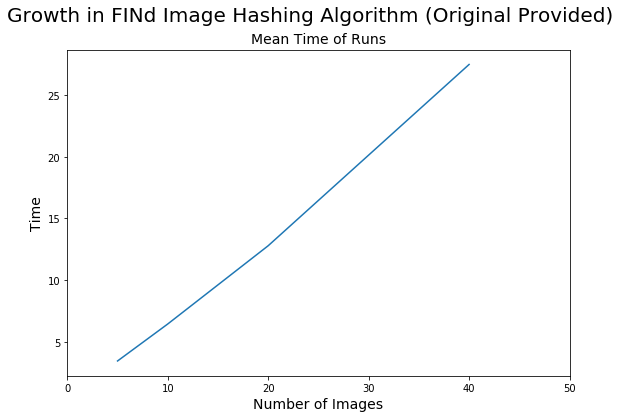

In [17]:
plt.figure(1, figsize = (9,6))
plt.plot(image_counts, mean_times)
plt.suptitle('Growth in FINd Image Hashing Algorithm (Original Provided)', fontsize = 20)
plt.title('Mean Time of Runs', fontsize = 14)
plt.xlabel('Number of Images', fontsize = 14)
plt.xticks(np.arange(0,60, 10))
plt.ylabel('Time',  fontsize = 14)

plt.savefig('image_docs/code_time_orig.png', bbox_inches = 'tight')
plt.show()

This initial work demonstrates that the function benchmarking_basic and the underlying code in FINd.py runs in essentially linear time (O_n) with respect to the number of images.

## Detailed Profiling

## High-Level Line Profiling

We can examine in detail the speed of the code, first using the in-built magic function %lprun from line profiler. This gives us a high-level overview of the code speed. We run ten images through the benchmarking function to see the relative speed in the function calls, and to abstract away from code due to the additional benchmakring_function calls.

In [8]:
%prun benchmarking_basic(10)

         5283424 function calls in 7.206 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    5.033    0.503    5.489    0.549 FINd.py:174(boxFilter)
       10    0.462    0.046    1.229    0.123 FINd.py:68(fillFloatLumaFromBufferImage)
   625000    0.295    0.000    0.766    0.000 Image.py:1360(getpixel)
   625040    0.270    0.000    0.360    0.000 Image.py:838(load)
  1250000    0.232    0.000    0.232    0.000 {built-in method builtins.max}
  1250000    0.224    0.000    0.224    0.000 {built-in method builtins.min}
    55974    0.176    0.000    0.176    0.000 {built-in method builtins.next}
   625000    0.110    0.000    0.110    0.000 {method 'getpixel' of 'ImagingCore' objects}
       10    0.106    0.011    0.106    0.011 FINd.py:117(dct64To16)
   625030    0.090    0.000    0.090    0.000 {method 'pixel_access' of 'ImagingCore' objects}
       10    0.068    0.007    0.068    0.007 {built-in method io.open

I have minimised the above (rather large) cell output for the sake of brevity, and show the clipped version below: 

![Image](image_docs/img-benchmarking-1image-defaultcode.PNG)

we can see the function BoxFilter is taking the most of amount of time, followed by FillFloatLumafromBufferImage.

Some back-of-the-envelope maths from these results (and similar runs) suggests that boxfilter takes around 60-70% of the time for the execution, and FillFloatLuma another 5%. BoxFilter is an obvious candidarte for optimisation, with FillFloatLuma behind that as well. 

## Detailed Line Profiling

### BoxFilter

Line profiler also offers extended functionality to profile code at the individual line level. The profiling of BoxFilter in the command line, clipped below, shows the inner loop of a 4-way nested function takes around 85% of the time:

![Image](image_docs/boxfilter_profiling_sm.PNG)


### FillFLoatLuma

A similar process for FillFloatLuma demonstrates that a loop in the conversion of the image to greyscale from the rgb values is taking up around 90 per cent of the time:

![Image](image_docs/fillfloatluma_profiling.PNG)

## Memory Profiling

Another question is around the size of the memory (RAM) used in the processing of these images.

In [9]:
%memit benchmarking_basic(10)

peak memory: 73.62 MiB, increment: 2.89 MiB


In [10]:
%memit benchmarking_basic(30)

peak memory: 74.45 MiB, increment: 1.84 MiB


The above output demonstrates that the size of the memory used in this processing is trivial for modern machines with multiple gigabytes of memory to assign, and does not scale significantly with the number of images input into the benchmarking function. As a result, we do not consider memory profiling as an important optimisation for this code.

## Optimisation - Numba

In [5]:
image_counts = [5, 10, 20, 40]
results = []

# Loop through the different numbers of hashes and store the %timeit results
for i in image_counts:
    result = %timeit -o rand_hashes = benchmarking_basic_1(i)
    results.append(result)

# Extract the mean run times from the %timeit object
mean_times_numba = []
for i in range(0, len(results)):
    mean_times_numba.append(np.mean(results[i].all_runs))

# plt.plot(mean_times_numba)

1.85 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.88 s ± 1.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.58 s ± 96.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
13.3 s ± 336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


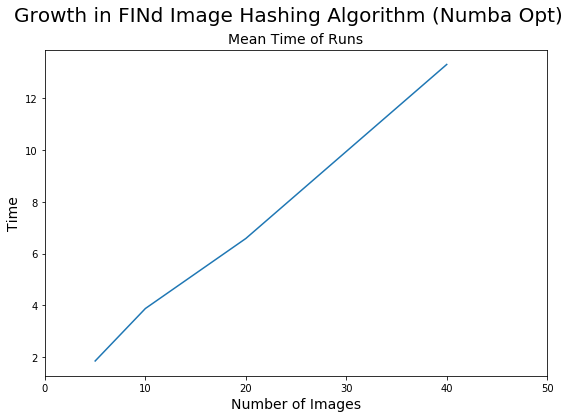

In [7]:
plt.figure(1, figsize = (9,6))
plt.plot(image_counts, mean_times_numba)
plt.suptitle('Growth in FINd Image Hashing Algorithm (Numba Opt)', fontsize = 20)
plt.title('Mean Time of Runs', fontsize = 14)
plt.xlabel('Number of Images', fontsize = 14)
plt.xticks(np.arange(0,60, 10))
plt.ylabel('Time',  fontsize = 14)

plt.savefig('image_docs/code_time_numba.png', bbox_inches = 'tight')
plt.show()

### Unit Testing

In [6]:
unit_1 = findHasher.fromFile("das_images/das_images/0040_10318987.jpg")
unit_2 = findHasher_1.fromFile("das_images/das_images/0040_10318987.jpg")

if unit_1 == unit_2:
    print("Unit test passed")
else:
    print('Unit test failed!')

Unit test passed


In [15]:
%prun benchmarking_basic_1(10)

         11821595 function calls in 5.090 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1153820    0.787    0.000    3.097    0.000 typeof.py:24(typeof)
  1153820    0.622    0.000    1.827    0.000 functools.py:822(wrapper)
  1153820    0.602    0.000    1.033    0.000 functools.py:768(dispatch)
       10    0.391    0.039    1.073    0.107 FINd_numba.py:85(fillFloatLumaFromBufferImage)
  1153820    0.340    0.000    0.340    0.000 weakref.py:395(__getitem__)
       10    0.340    0.034    3.436    0.344 FINd_numba.py:14(faster_boxFilter)
  1153820    0.277    0.000    0.483    0.000 <string>:1(__new__)
   576900    0.267    0.000    0.679    0.000 Image.py:1360(getpixel)
   576940    0.228    0.000    0.310    0.000 Image.py:838(load)
    55974    0.214    0.000    0.214    0.000 {built-in method builtins.next}
  1153820    0.205    0.000    0.205    0.000 {built-in method __new__ of type object at 0x00007FFB87F26BA0}

## Failed Attempt to Optimise FillFloatLuma

In [14]:
# Very frustrating. Could not figure out why this new findhasher optimisations just returned zero. Spent a lot of hours on this.

unit_1 = findHasher.fromFile("das_images/das_images/0040_10318987.jpg")
unit_2 = findHasher_4.fromFile("das_images/das_images/0040_10318987.jpg")

if unit_1 == unit_2:
    print("Unit test passed")
else:
    print('Unit test failed!')

buffer1 is type:  <class 'list'>
Unit test failed!


## Potential Optimisation - MultiProcessing

We run the original code but with optimisations from multiprocessing

In [9]:
%%timeit -r5

test = benchmarking_basic(40)

28.3 s ± 772 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [10]:
%%timeit -r5

# split jobs
map_list = [20, 20]

with multiprocessing.Pool(2) as pool:
        test = pool.map(benchmarking_basic, map_list)

16.7 s ± 654 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


Splitting up the benchmarking function into two threads that runs ten images each leads to speed up of almost 40%.

### Combined Optimisation - Multiprocessing and Numba

In [11]:
%%timeit -r5

# split jobs
map_list = [20, 20]

with multiprocessing.Pool(2) as pool:
        test = pool.map(benchmarking_basic_1, map_list)

10.3 s ± 642 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


## Potential Optimisation - Hardware

In cases where a CPU bottleneck is suspected, different hardware may provide a speedup. Although I personally have limited access to additional hardware for testing, Google provides free CPUs, GPUs and TPUs through the Google Colab Platform. The below cells show the benchmarking_basic function loop ran as above, first on Google Colab's default CPU hardware, then the GPU hardware, and finally the TPU hardware.

<font color='red'>**Note to markers - you can only re-run this code in a Google Colab environment with DAS data in GDrive and/or in memory**</font>



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os, os.path
from random import sample

In [4]:
# Checking the sample of images I managed to upload - I had issues with Google Drive syncing a large number of files. This sample is reasonable enough.
# An alternative to test this might be to upload the files to Git and downloading from there (although you might need a public repo for that). 

list = os.listdir('/content/gdrive/My Drive/DAS Summative/das_images/das_images')
number_files = len(list)
print(number_files)

15057


In [ ]:
# List of filenames only

img_filename_list = []
for root, dirs, files in os.walk('/content/gdrive/My Drive/DAS Summative/das_images/das_images'):
    for file in files:
        if file.endswith('.jpg'):
            img_filename_list.append(file)

In [ ]:
# List of full paths to sample and load into memory

img_filename_list_fullpath = []
for root, dirs, files in os.walk('/content/gdrive/My Drive/DAS Summative/das_images/das_images'):
    for file in files:
        if file.endswith('.jpg'):
            file_full = '/content/gdrive/My Drive/DAS Summative/das_images/das_images/' + file
            img_filename_list_fullpath.append(file_full)

In [8]:
display(len(img_filename_list_fullpath))
img_filename_list_fullpath[0]

15056

'/content/gdrive/My Drive/DAS Summative/das_images/das_images/0014_10752956.jpg'

In [ ]:
# Set directory to get code
os.chdir('/content/gdrive/My Drive/DAS Summative/')

In [10]:
# Check we have what we need
list = os.listdir('/content/gdrive/My Drive/DAS Summative')
print(list)

['das_images', 'matrix.py', 'FINd_gg.py', '__pycache__', 'FINd_numba_gg.py']


In [11]:
# Install imagehash
!pip install ImageHash

     |████████████████████████████████| 296kB 9.2MB/s eta 0:00:01


In [12]:
# Typical preamble

%pylab inline

# %load_ext memory_profiler

from FINd_gg import FINDHasher
from FINd_gg import benchmarking_basic

from FINd_numba_gg import FINDHasher_1
from FINd_numba_gg import benchmarking_basic_1

import imagehash
from PIL import Image

import time
import os
from random import sample
import numpy as np

import multiprocessing

import matplotlib.pyplot as plt

import itertools

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Loading Files into Google Collab Memory and Working That Way

In [ ]:
find = FINDHasher()

### Using Google's default CPU hardware - From Google Drive

1 loop, best of 3: 5.6 s per loop
1 loop, best of 3: 10.6 s per loop
1 loop, best of 3: 20.9 s per loop
1 loop, best of 3: 42.4 s per loop


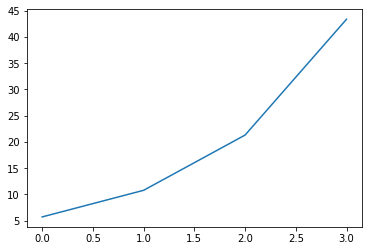

In [20]:
# Google's default CPU Hardware

# Image numbers to hash and result list
image_counts = [5, 10, 20, 40]
results = []

# Loop through the different numbers of hashes and store the %timeit results
for i in image_counts:
    result = %timeit -o rand_hashes = benchmarking_basic(i)
    results.append(result)

# Extract the mean run times from the %timeit object
mean_times = []
for i in range(0, len(results)):
    mean_times.append(np.mean(results[i].all_runs))

plt.plot(mean_times)

#### Reason for Generally Slow Speed on Google's CPU

Google's provided free CPU is actually slightly slower than the CPU execution on my rather dated 2016 Surface Pro (around 1 second per image in the benchmarking_basic function). I suspected this was due to Google-Collab specific factors rather than Google using old hardware, and the output of %lprun on Google's hardware suggests this is true:

![Image](image_docs/img-googlecollab-defaultprun.PNG)

The top line of output here shows that the I/O process method 'read' of '__io.BufferedReader' is taking significant time, indeed, even more than the boxFilter. This suggests that the Python process is ***probably*** waiting a substantial amount of system time to load information from the Google Drive environment before being able to execute code, although I am not certain of this fact.

Nonetheless, this delay is relatively stable, and provides a useful benchmark for comparing to other hardware Google provides.



### Using Google's GPU hardware - From Google Drive

1 loop, best of 3: 3.88 s per loop
1 loop, best of 3: 7.73 s per loop
1 loop, best of 3: 15.2 s per loop
1 loop, best of 3: 29.7 s per loop


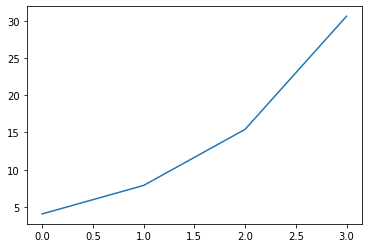

In [11]:
# Run on Google's Provided GPU Hardware

# Image numbers to hash and result list
image_counts = [5, 10, 20, 40]
results = []

# Loop through the different numbers of hashes and store the %timeit results
for i in image_counts:
    result = %timeit -o rand_hashes = benchmarking_basic(i)
    results.append(result)

# Extract the mean run times from the %timeit object
mean_times = []
for i in range(0, len(results)):
    mean_times.append(np.mean(results[i].all_runs))

plt.plot(mean_times)

Process execution on Google's hardware is slightly slower than my own computer due to IO delays, likely from when Python accesses data from Google Drive. Nonethless, this delay is constant for each run of the code and for all the hardware Google uses, and so provides a useful comparison.

Google's GPU hardware is faster than the CPU. 

As we would expect, all of Google's hardware also appears to run this algorithm in linear time with respect to the number of images. 

### Using Google's Hardware - Files In Memory

We then turn to running these algorithms with images in Memory, to avoid the input output issues from using Google Drive.

In [ ]:
# List of full paths to sample and load into memory

img_filename_list_fullpath = []
for root, dirs, files in os.walk('/content/gdrive/My Drive/DAS Summative/das_images/das_images'):
    for file in files:
        if file.endswith('.jpg'):
            file_full = '/content/gdrive/My Drive/DAS Summative/das_images/das_images/' + file
            img_filename_list_fullpath.append(file_full)

In [8]:
display(len(img_filename_list_fullpath))
img_filename_list_fullpath[0]

15056

'/content/gdrive/My Drive/DAS Summative/das_images/das_images/0014_10752956.jpg'

In [ ]:
sample_images_filenames = sample(img_filename_list_fullpath, 20)

In [ ]:
imgs_in_mem_list = []

for i in range(len(sample_images_filenames)):
    imgs_in_mem_list.append(Image.open(sample_images_filenames[i]))

In [12]:
# To run on the default CPU hardware - 20 images - around 0.445ms per image

%%timeit

hash_list = []

for i in range(len(imgs_in_mem_list)):
    temphash = find.fromImage(imgs_in_mem_list[i])
    hash_list.append(temphash)
    temphash = []

1 loop, best of 3: 9.03 s per loop


In [15]:
# RUn on the default GPU hardware - 20 images, around 0.382 seconds per image

%%timeit

hash_list = []

for i in range(len(imgs_in_mem_list)):
    temphash = find.fromImage(imgs_in_mem_list[i])
    hash_list.append(temphash)
    temphash = []

1 loop, best of 3: 7.63 s per loop


In [16]:
# This output comes up as a pop up window in GOogle Colab.
# Shown in the PDF report

%prun find.fromImage(imgs_in_mem_list[0])

## Fastest Run of Code - Numba Optimisation on Google's GPUs

In [22]:
find_1 = FINDHasher_1()

In [15]:
# RUn on the default GPU hardware - 20 images, numba optimised code, around 0.22 seconds per image

# 20 images


%%timeit

hash_list = []

for i in range(len(imgs_in_mem_list)):
    temphash = find_1.fromImage(imgs_in_mem_list[i])
    hash_list.append(temphash)
    temphash = []

1 loop, best of 3: 4.4 s per loop


# Accuracy Measurement and Comparisons

## Profiling Other Algorithms

In [18]:
findHasher_1=FINDHasher_1()

In [17]:
img_filename_list = []
for root, dirs, files in os.walk(r'C:/Users/REDACTED/Desktop/Oxford/Summatives/das2019/das_images/das_images'):
    for file in files:
        if file.endswith('.jpg'):
            img_filename_list.append(file)

findHasher_1

In [19]:
%%timeit 
img_sample = sample(img_filename_list, 10)
hash_output_base = []
for i in range(0,len(img_sample)):   
    img_string_input = 'das_images/das_images/{}'.format(img_sample[i])
    hash_temp = findHasher_1.fromFile(img_string_input)
    hash_output_base.append(hash_temp)

2.99 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Average Hasher

In [20]:
%%timeit 
img_sample = sample(img_filename_list, 10)
hash_output_avg = []
for i in range(0,len(img_sample)):    
    img_string_input = 'das_images/das_images/{}'.format(img_sample[i])
    hash_temp = imagehash.average_hash(Image.open(img_string_input))    
    hash_output_avg.append(hash_temp)

70.2 ms ± 5.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Perceptual Hasher

In [22]:
%%timeit 
img_sample = sample(img_filename_list, 10)
hash_output = []
for i in range(0,len(img_sample)):    
    img_string_input = 'das_images/das_images/{}'.format(img_sample[i])
    hash_temp = imagehash.phash(Image.open(img_string_input))    
    hash_output.append(hash_temp)

87.1 ms ± 8.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Accuracy for FINDHasher

In [6]:
# I want to randomly sample from the list of images to for accuracy distributions
# This code reads in a list of all the image filenames in the images folder

img_filename_list = []
for root, dirs, files in os.walk(r'C:/Users/REDACTED/Desktop/Oxford/Summatives/das2019/das_images/das_images'):
    for file in files:
        if file.endswith('.jpg'):
            img_filename_list.append(file)

In [8]:
# generate a list of all the unique meme image groups from the filenames
# The image group is specified by the first four digits of the file name

list_image_prefixes = []

for i in range(0, len(img_filename_list)):
    temp_prefix = img_filename_list[i][0:4]
    list_image_prefixes.append(temp_prefix)

unique_image_groups = set(list_image_prefixes)

In [9]:
# Sort the image filenames into their meme families in a dictionary

meme_lord_dict = {}
for file_name in img_filename_list:
    if file_name[0:4] in meme_lord_dict:
        meme_lord_dict[file_name[0:4]].append(file_name)
    else:
        meme_lord_dict[file_name[0:4]]=[file_name]

In [15]:
# Choose a specified a number of meme families to test within
sample_meme_types = sample(meme_lord_dict.keys(), 10)

hash_output_dict = {}

# Loop over the chosen meme families
for i in range(0, len(sample_meme_types)):
    
    # Choose a specified number of images selected within each meme family to test
    img_to_hash = sample(meme_lord_dict[sample_meme_types[i]], 10)
    
    # Loop over the images in each meme family and store the hashes
    for j in range(0, len(img_to_hash)):
        img_string_input = 'das_images/das_images/{}'.format(img_to_hash[j])
        hash_temp = findHasher_1.fromFile(img_string_input)
        
        if img_to_hash[j][0:4] in hash_output_dict:
            
            # If the dictionary already has a key for that image family, just append the hash output
            hash_output_dict[img_to_hash[j][0:4]].append(hash_temp)
        else:
            # If there is no key for that meme family yet, add it and put the hash_temp in
            hash_output_dict[img_to_hash[j][0:4]]=[hash_temp]

C:\ProgramData\Anaconda3\lib\site-packages\numba\ir_utils.py:1969: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'input' of function 'faster_boxFilter'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "FINd_numba.py", line 15:
@jit
def faster_boxFilter(input,output,rows,cols,rowWin,colWin):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\ProgramData\Anaconda3\lib\site-packages\numba\ir_utils.py:1969: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'output' of function 'faster_boxFilter'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "FINd_numba.py", line 15:
@jit
def faster_boxFilt

In [16]:
# Collect all unique-pair intra-meme-family distances

# grab the list of meme family keys we 
keys_list = list(hash_output_dict.keys())

hash_dist_temp = []
distances_dict = {}

for i in range(0, len(keys_list)):
    
    # Compute all unique distance combinations
    for a, b in itertools.combinations(hash_output_dict[keys_list[i]], 2):
        temp_dist = a - b
        hash_dist_temp.append(temp_dist)
    
    # pop the hash distance list into the dictionary with the meme family key
    distances_dict[keys_list[i]] = [hash_dist_temp]
    
    # clear hash_dist_temp for next iteration
    hash_dist_temp = []

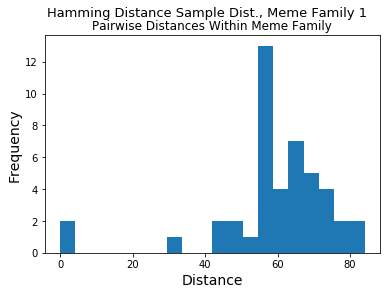

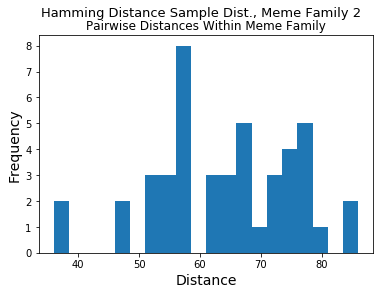

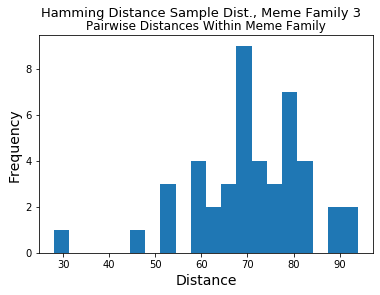

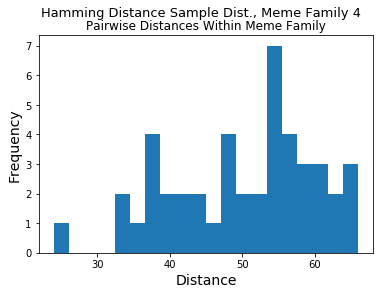

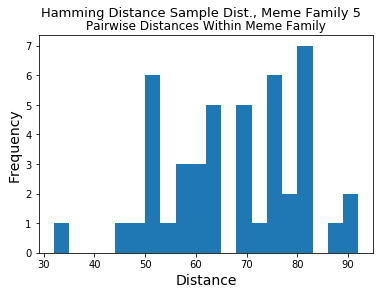

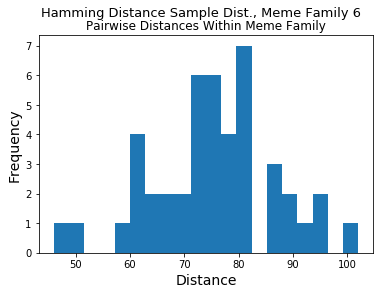

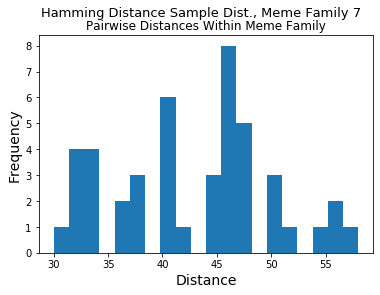

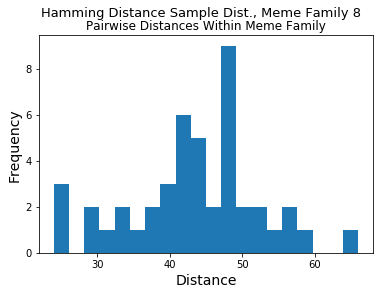

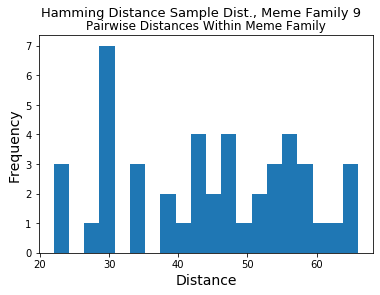

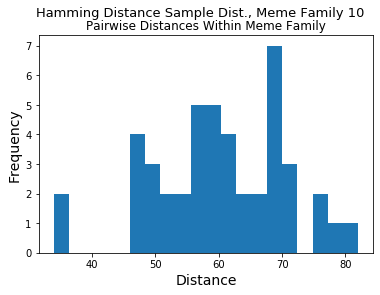

In [30]:
# Distribution graphs for FINDHasher

for i in range(0, len(keys_list)):
    plt.figure()
    plt.hist(distances_dict[keys_list[i]][0], bins = 20)
    plt.suptitle('Hamming Distance Sample Dist., Meme Family {}'.format(i+1), fontsize = 13)
    plt.title('Pairwise Distances Within Meme Family', fontsize = 12)
    plt.xlabel('Distance', fontsize = 14)
    # plt.xticks(np.arange(0,60, 10))
    plt.ylabel('Frequency',  fontsize = 14)
    plt.savefig('image_docs/hamm_dist_{}.png'.format(i+1), bbox_inches = 'tight')
plt.show()

In [92]:
final_results_findhasher = []
threshold = 50

thresh_list = np.arange(0,105,5)

for z in range(len(thresh_list)):

    results_of_thresh_test = {}


    for i in range(len(dist_keys)):

        for j in range(len(distances_dict[dist_keys[i]][0])):

            if distances_dict[dist_keys[i]][0][j] > thresh_list[z]:
                result = 0
            else: 
                result = 1

            if dist_keys[i] in results_of_thresh_test:

                # If the dictionary already has a key for that image family, just append the hash output
                results_of_thresh_test[dist_keys[i]].append(result)
            else:
                # If there is no key for that meme family yet, add it and put the hash_temp in
                results_of_thresh_test[dist_keys[i]]=[result]


    result_flat = []
    for q in range(len(dist_keys)):

        result_array = np.array(results_of_thresh_test[dist_keys[q]])
        per_cent = result_array.mean()
        result_flat.append(per_cent)

    result_flat_grab = np.array(result_flat)


    final_results_findhasher.append(result_flat_grab.mean())
    #final_results[thresh_list[z]]=[result_flat_grab.mean()]

In [93]:
final_results_findhasher

[0.008888888888888889,
 0.008888888888888889,
 0.011111111111111112,
 0.011111111111111112,
 0.028888888888888888,
 0.07555555555555554,
 0.14888888888888888,
 0.1866666666666667,
 0.31111111111111117,
 0.4066666666666666,
 0.5177777777777777,
 0.6266666666666667,
 0.7377777777777778,
 0.8266666666666665,
 0.9066666666666668,
 0.9400000000000001,
 0.9822222222222223,
 0.9911111111111112,
 0.9977777777777778,
 1.0,
 1.0]

### Accuracy Metric for AverageHash

In [95]:
# I want to randomly sample from the list of images to for accuracy distributions
# This code reads in a list of all the image filenames in the images folder

img_filename_list = []
for root, dirs, files in os.walk(r'C:/Users/REDACTED/Desktop/Oxford/Summatives/das2019/das_images/das_images'):
    for file in files:
        if file.endswith('.jpg'):
            img_filename_list.append(file)

In [96]:
# generate a list of all the unique meme image groups from the filenames
# The image group is specified by the first four digits of the file name

list_image_prefixes = []

for i in range(0, len(img_filename_list)):
    temp_prefix = img_filename_list[i][0:4]
    list_image_prefixes.append(temp_prefix)

unique_image_groups = set(list_image_prefixes)

In [97]:
# Sort the image filenames into their meme families in a dictionary

meme_lord_dict = {}
for file_name in img_filename_list:
    if file_name[0:4] in meme_lord_dict:
        meme_lord_dict[file_name[0:4]].append(file_name)
    else:
        meme_lord_dict[file_name[0:4]]=[file_name]

In [98]:
# Choose a specified a number of meme families to test within
sample_meme_types = sample(meme_lord_dict.keys(), 10)

hash_output_dict = {}

# Loop over the chosen meme families
for i in range(0, len(sample_meme_types)):
    
    # Choose a specified number of images selected within each meme family to test
    img_to_hash = sample(meme_lord_dict[sample_meme_types[i]], 10)
    
    # Loop over the images in each meme family and store the hashes
    for j in range(0, len(img_to_hash)):
        img_string_input = 'das_images/das_images/{}'.format(img_to_hash[j])
        hash_temp = imagehash.average_hash(Image.open(img_string_input))
        
        if img_to_hash[j][0:4] in hash_output_dict:
            
            # If the dictionary already has a key for that image family, just append the hash output
            hash_output_dict[img_to_hash[j][0:4]].append(hash_temp)
        else:
            # If there is no key for that meme family yet, add it and put the hash_temp in
            hash_output_dict[img_to_hash[j][0:4]]=[hash_temp]

In [100]:
import itertools

# Collect all unique-pair intra-meme-family distances

# grab the list of meme family keys we 
keys_list = list(hash_output_dict.keys())

hash_dist_temp = []
distances_dict = {}

for i in range(0, len(keys_list)):
    
    # Compute all unique distance combinations
    for a, b in itertools.combinations(hash_output_dict[keys_list[i]], 2):
        temp_dist = a - b
        hash_dist_temp.append(temp_dist)
    
    # pop the hash distance list into the dictionary with the meme family key
    distances_dict[keys_list[i]] = [hash_dist_temp]
    
    # clear hash_dist_temp for next iteration
    hash_dist_temp = []

In [106]:
dist_keys = list(distances_dict.keys())

final_results_avghash = []
threshold = 50

thresh_list = np.arange(0,105,5)

for z in range(len(thresh_list)):

    results_of_thresh_test = {}


    for i in range(len(dist_keys)):

        for j in range(len(distances_dict[dist_keys[i]][0])):

            if distances_dict[dist_keys[i]][0][j] > thresh_list[z]:
                result = 0
            else: 
                result = 1

            if dist_keys[i] in results_of_thresh_test:

                # If the dictionary already has a key for that image family, just append the hash output
                results_of_thresh_test[dist_keys[i]].append(result)
            else:
                # If there is no key for that meme family yet, add it and put the hash_temp in
                results_of_thresh_test[dist_keys[i]]=[result]


    result_flat = []
    for q in range(len(dist_keys)):

        result_array = np.array(results_of_thresh_test[dist_keys[q]])
        per_cent = result_array.mean()
        result_flat.append(per_cent)

    result_flat_grab = np.array(result_flat)


    final_results_avghash.append(result_flat_grab.mean())
    #final_results[thresh_list[z]]=[result_flat_grab.mean()]

In [107]:
final_results_avghash

[0.01111111111111111,
 0.42000000000000004,
 0.8355555555555556,
 0.9666666666666668,
 0.9911111111111112,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

## Accuracy Test Phash

In [111]:
# I want to randomly sample from the list of images to for accuracy distributions
# This code reads in a list of all the image filenames in the images folder

img_filename_list = []
for root, dirs, files in os.walk(r'C:/Users/REDACTED/Desktop/Oxford/Summatives/das2019/das_images/das_images'):
    for file in files:
        if file.endswith('.jpg'):
            img_filename_list.append(file)

In [112]:
# generate a list of all the unique meme image groups from the filenames
# The image group is specified by the first four digits of the file name

list_image_prefixes = []

for i in range(0, len(img_filename_list)):
    temp_prefix = img_filename_list[i][0:4]
    list_image_prefixes.append(temp_prefix)

unique_image_groups = set(list_image_prefixes)

In [113]:
# Sort the image filenames into their meme families in a dictionary

meme_lord_dict = {}
for file_name in img_filename_list:
    if file_name[0:4] in meme_lord_dict:
        meme_lord_dict[file_name[0:4]].append(file_name)
    else:
        meme_lord_dict[file_name[0:4]]=[file_name]

In [117]:
# Choose a specified a number of meme families to test within
sample_meme_types = sample(meme_lord_dict.keys(), 10)

hash_output_dict = {}

# Loop over the chosen meme families
for i in range(0, len(sample_meme_types)):
    
    # Choose a specified number of images selected within each meme family to test
    img_to_hash = sample(meme_lord_dict[sample_meme_types[i]], 10)
    
    # Loop over the images in each meme family and store the hashes
    for j in range(0, len(img_to_hash)):
        img_string_input = 'das_images/das_images/{}'.format(img_to_hash[j])
        hash_temp = imagehash.phash(Image.open(img_string_input))
        
        if img_to_hash[j][0:4] in hash_output_dict:
            
            # If the dictionary already has a key for that image family, just append the hash output
            hash_output_dict[img_to_hash[j][0:4]].append(hash_temp)
        else:
            # If there is no key for that meme family yet, add it and put the hash_temp in
            hash_output_dict[img_to_hash[j][0:4]]=[hash_temp]

In [118]:
import itertools

# Collect all unique-pair intra-meme-family distances

# grab the list of meme family keys we 
keys_list = list(hash_output_dict.keys())

hash_dist_temp = []
distances_dict = {}

for i in range(0, len(keys_list)):
    
    # Compute all unique distance combinations
    for a, b in itertools.combinations(hash_output_dict[keys_list[i]], 2):
        temp_dist = a - b
        hash_dist_temp.append(temp_dist)
    
    # pop the hash distance list into the dictionary with the meme family key
    distances_dict[keys_list[i]] = [hash_dist_temp]
    
    # clear hash_dist_temp for next iteration
    hash_dist_temp = []

In [ ]:

for i in range(0, len(keys_list)):
    plt.figure()
    plt.hist(distances_dict[keys_list[i]][0], bins = 20)
    plt.suptitle('Hamming Distance Sample Dist., Meme Family {}'.format(i+1), fontsize = 13)
    plt.title('Pairwise Distances Within Meme Family', fontsize = 12)
    plt.xlabel('Distance', fontsize = 14)
    # plt.xticks(np.arange(0,60, 10))
    plt.ylabel('Frequency',  fontsize = 14)
    plt.savefig('image_docs/hamm_dist_{}.png'.format(i+1), bbox_inches = 'tight')
plt.show()

In [120]:
dist_keys = list(distances_dict.keys())

final_results_phash = []
threshold = 50

thresh_list = np.arange(0,105,5)

for z in range(len(thresh_list)):

    results_of_thresh_test = {}


    for i in range(len(dist_keys)):

        for j in range(len(distances_dict[dist_keys[i]][0])):

            if distances_dict[dist_keys[i]][0][j] > thresh_list[z]:
                result = 0
            else: 
                result = 1

            if dist_keys[i] in results_of_thresh_test:

                # If the dictionary already has a key for that image family, just append the hash output
                results_of_thresh_test[dist_keys[i]].append(result)
            else:
                # If there is no key for that meme family yet, add it and put the hash_temp in
                results_of_thresh_test[dist_keys[i]]=[result]


    result_flat = []
    for q in range(len(dist_keys)):

        result_array = np.array(results_of_thresh_test[dist_keys[q]])
        per_cent = result_array.mean()
        result_flat.append(per_cent)

    result_flat_grab = np.array(result_flat)


    final_results_phash.append(result_flat_grab.mean())
    #final_results[thresh_list[z]]=[result_flat_grab.mean()]

In [121]:
final_results_phash

[0.013333333333333332,
 0.21777777777777776,
 0.7044444444444444,
 0.9355555555555555,
 0.9800000000000001,
 0.9800000000000001,
 0.9888888888888889,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

## Accuracy Summary

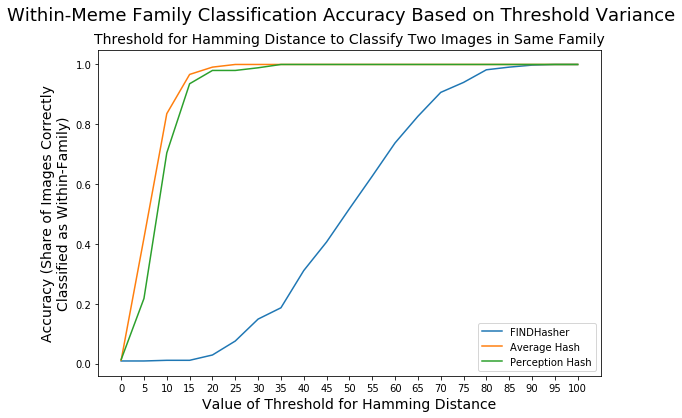

In [148]:
plt.figure(1, figsize = (9,6))
plt.plot(np.arange(0,105,5), final_results_findhasher,)
plt.plot(np.arange(0,105,5), final_results_avghash)
plt.plot(np.arange(0,105,5), final_results_phash)
plt.xticks(np.arange(0,105,5),np.arange(0,105,5))
plt.legend(('FINDHasher', 'Average Hash', 'Perception Hash'))
plt.suptitle('Within-Meme Family Classification Accuracy Based on Threshold Variance', fontsize = 18)
plt.title('Threshold for Hamming Distance to Classify Two Images in Same Family', fontsize = 14)
plt.xlabel('Value of Threshold for Hamming Distance', fontsize = 14)
plt.ylabel('Accuracy (Share of Images Correctly\nClassified as Within-Family)',  fontsize = 14)

plt.savefig('image_docs/accuracy_measure.png', bbox_inches = 'tight')
plt.show()